# Laboratorio di simulazione numerica

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
import numpy as np
import math
import string
import os

#### Exercise 08.1

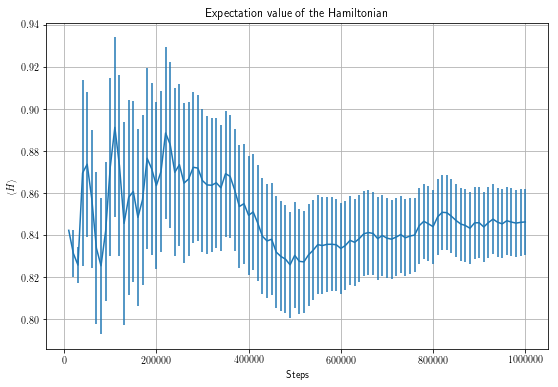

In [2]:
steps, avg, err = np.loadtxt("exercise08-1/energy.dat", unpack = True)

plt.figure(1, figsize = (9,6))
plt.errorbar(steps, avg, yerr = err)
plt.title("Expectation value of the Hamiltonian")
plt.ylabel(r"$\langle H\rangle$")
plt.xlabel("Steps")
plt.grid(True)
plt.show()

#### Exercise 08.2

In [90]:
prefix = "exercise08-2/"
old_pwd = !pwd
old_pwd = str(old_pwd[0])
#os.chdir(old_pwd + "/" + prefix)
os.chdir("/home/studenti/davide.ferracin/lab-simulazione-numerica/exercise08/exercise08-2/")
# This hardcoded path has to go as soon as possible.
# It prevents this code to be run anywhere else but
# the physics department computer lab. But for now...

N = 10
# Define a grid of values for mu and sigma to run the program with.
mu = np.linspace(0.6, 1.3, N)
sigma = np.linspace(0.6, 01.3, N)
data = np.zeros((N, N))
for (i_m, m) in enumerate(mu):
    for (i_s, s) in enumerate(sigma):
        # Run the program with the given values.
        os.system("./exercise08-2 %.3f" % (m) + " " + "%.3f" % (s))
        # Get the computed energy (average + uncertainty), reading the
        # last line of the output file.
        with open("energy.dat") as output:
            result = list(output)[-1].split()
        data[i_m][i_s] = float(result[1])  

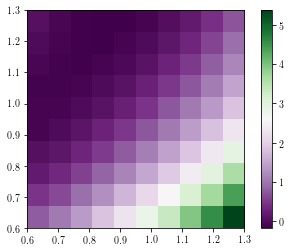

In [91]:
# A colour plot to visualise the results of the simulations
# above.
fig = plt.figure()
im = plt.imshow(data, extent = (mu[0], mu[-1], sigma[0], sigma[-1]), cmap = matplotlib.cm.PRGn)
fig.colorbar(im)
plt.show()

Apparently the minimum lies in the dark violet region in the upper left corner. I find it hard to believe, given the results in the cells below. I need to investigate it more.

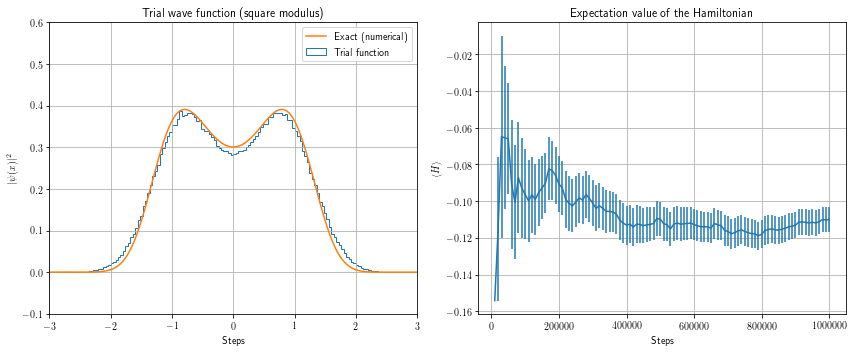

In [95]:
# When the minimum has been found, calculate the expectation value
# of the Hamiltonian and visualize the wave function.

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

best_mu, best_sigma = 0.85, 0.675
# These two values were NOT found by minimizing the energy in the
# calculations above. They were chosen, after some trial and error,
# such that the pdf of the trial wave function resembled the most
# the numerical solution written below.

os.chdir("/home/studenti/davide.ferracin/lab-simulazione-numerica/exercise08/exercise08-2/")
os.system("./exercise08-2 %.3f" % (best_mu) + " " + "%.3f" % (best_sigma))
# Gather the data.
drawn_points = np.loadtxt("drawn_points.dat", unpack = True)
steps, avg, err = np.loadtxt("energy.dat", unpack = True)

# Histogram of the square modulus of the wave function.
axes[0].hist(drawn_points, bins = 200, range = (-4, 4), density = True, histtype = "step", label = "Trial function")
axes[0].set_title("Trial wave function (square modulus)")
axes[0].set_ylabel(r"$|\psi(x)|^2$")
axes[0].set_xlabel("Steps")
axes[0].grid(True)

# Expectation value of the Hamiltonian.
axes[1].errorbar(steps, avg, yerr = err)
axes[1].set_title("Expectation value of the Hamiltonian")
axes[1].set_ylabel(r"$\langle H\rangle$")
axes[1].set_xlabel("Steps")
axes[1].grid(True)

# Numerical approximation of the exact probability density.
n_points = 1000 # Number of iterations
x = np.linspace(-4, 4, n_points)
dx = x[1] - x[0] # Step size

# Discrete "second derivative matrix operator": multiply a
# vector by this matrix and divide by the step size to
# obtain its discrete second derivative, calculated using
# the central differences method
# f'' = (f_1 - 2 f_0 + f_-1) / dx^2.
laplacian = np.diag(np.ones(n_points-1),-1)-2*np.diag(np.ones(n_points),0)+np.diag(np.ones(n_points-1),1)

# Potential energy
V = [(p**2 - 2.5) * p**2 for p in x]
# Hamiltonian matrix
H = -laplacian / (2 * dx**2) + np.diag(V)

# Compute the eigenvectors and their eigenvalues.
E, psi = np.linalg.eigh(H)

# Take the transpose, then normalize.
psi = np.transpose(psi)
psi = psi / np.sqrt(dx)

axes[0].plot(x, (psi[0])**2, label = "Exact (numerical)")
axes[0].set_xlim((-3,3))
axes[0].set_ylim((-0.1,0.6))
axes[0].legend()

fig.tight_layout()
plt.show()